# Multilayer Perceptron (MLP) Model

For this section of the project, we will train, test, and evaluate a Multilayer Perceptron (MLP) model using PyTorch, leveraging core modules such as `torch`, `torch.nn`, `torch.optim`, and `torch.utils.data` for model construction, optimization, and data handling. The UCI Adult Income dataset will serve as our dataset for classification.

We will accomplish the following in this notebook:

- Load & preprocess the dataset
- Train and test MLP model on dataset while tunning parameters to develop multiple candidates
- Evaluate models using appropriate metrics
- Select thge most promising model
- Predict response variable for validation inputs by using most promising model
- Monitor and mitigate overfitting

---

## 1. Load & Preprocess Data

We load the UCI Adult Income dataset, clean it, encode categorical variables, scale numerical features, and split features/labels. We also standardize continuous columns using `StandardScaler` from `sklearn` so that the MLP can train more efficiently in PyTorch.

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_data(df: pd.DataFrame, scaler: StandardScaler | None = None):
    """
    Preprocessing for the Adult Income flat file.

    - Strip strings, turn '?' -> 'Unknown'
    - Keep all rows (do not drop missing placeholders)
    - Drop 'education' (keep 'education-num')
    - One-hot encode categoricals
    - Encode target 'income' to {<=50K:0, >50K:1} if present
    - Standardize numeric columns (fit on train if scaler is None; otherwise transform)

    Returns
    -------
    X : DataFrame
    y : Series | None
    scaler : StandardScaler
    """
    # fixed columns
    cat_cols = ['workclass', 'education', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'native-country']
    num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'hours-per-week']

    df = df.copy()
    has_target = 'income' in df.columns

    # 1) clean strings/placeholders
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].map(lambda x: x.strip() if isinstance(x, str) else x)
    df.replace('?', 'Unknown', inplace=True)

    # 2) drop redundant education (keep 'education-num')
    if 'education' in df.columns:
        df.drop(columns=['education'], inplace=True, errors='ignore')

    # 3) one-hot encode categoricals
    ohe_cols = [c for c in cat_cols if c != 'education' and c in df.columns]
    if ohe_cols:
        df = pd.get_dummies(df, columns=ohe_cols, dtype=int)

    # 4) split target
    y = None
    if has_target:
        df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})
        y = df['income'].astype('int64')
        X = df.drop(columns=['income'])
    else:
        X = df

    # 5) standardize numerics (no dtype warning fix)
    present_num = [c for c in num_cols if c in X.columns]
    fitted_scaler = scaler or StandardScaler()
    if present_num:
        # get numeric block as float
        numeric_block = X.loc[:, present_num].astype('float64', copy=True)

        if scaler is None:
            scaled_vals = fitted_scaler.fit_transform(numeric_block)
        else:
            scaled_vals = fitted_scaler.transform(numeric_block)

        # assign back column-by-column to avoid dtype conflict
        for i, col in enumerate(present_num):
            X[col] = scaled_vals[:, i]

    return X, y, fitted_scaler

Now, we will **load the raw dataset** and **split it into training and validation sets**. We’ll then **apply the** `preprocess_data()` function to both sets to clean, encode, and standardize the data for model training.

In [39]:
# Load data
adult_df = pd.read_csv('../data/raw/project_adult.csv', index_col=0)

# Train/Validation split
train_df, val_df = train_test_split(adult_df, test_size=0.2, random_state=42, stratify=adult_df["income"])

# Preprocess (Fit scaler on train & Reuse scaler on val)
X_train, y_train, scaler = preprocess_data(train_df, scaler=None)
X_val, y_val, _ = preprocess_data(val_df, scaler=scaler)

# Align columns between train and val 
train_cols = X_train.columns

# Reindex validation to match training columns exactly
X_val = X_val.reindex(columns=train_cols, fill_value=0)

print("X_train shape:", X_train.shape)
print("X_val shape:  ", X_val.shape)
print("y_train dist:\n", y_train.value_counts(normalize=True).rename("proportion"))

X_train shape: (20838, 91)
X_val shape:   (5210, 91)
y_train dist:
 income
0    0.759286
1    0.240714
Name: proportion, dtype: float64


Saving preprocessed dataframes:

In [40]:
from pathlib import Path

# Ensure processed folder exists (one level up)
processed_path = Path("../data/processed")
processed_path.mkdir(parents=True, exist_ok=True)

# Save preprocessed datasets
X_train.to_csv(processed_path / "X_train.csv", index=False)
y_train.to_csv(processed_path / "y_train.csv", index=False)
X_val.to_csv(processed_path / "X_val.csv", index=False)
y_val.to_csv(processed_path / "y_val.csv", index=False)

print(f"Preprocessed data saved in: {processed_path.resolve()}")

Preprocessed data saved in: C:\Users\jonat\Desktop\Fall 2025\Machine Learning\mlp-uci-adultincome\data\processed


Next step:

- We'll convert `X_train`, `y_train`, `X_val`, `y_val` to PyTorch tensors and wrap them in `TensorDataset` / `DataLoader`.

---

## 2. Prepare Data for PyTorch

In this section, we will convert our preprocessed training and validation datasets into **PyTorch tensors** and wrap them into **DataLoaders** for efficient mini-batch training. DataLoaders handle batching, shuffling, and parallel loading, which helps improve training performance.

In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64  # common starting point; we'll tune this later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 326
Validation batches: 82


For our batch size we went with **64** since its the most common starting point. we will tune this later to see if we observe better results. 

In the next section we will define the actual MLP architecture in PyTorch (`nn.Module`), including layers, activations, and dropout. We'll also record input_dim and output_dim from the data so the model builds itself correctly.

---

## 3. Define the MLP Architecture

We define a feedforward neural network (Multilayer Perceptron) in PyTorch using `torch.nn.Module`. The model consists of fully connected (`Linear`) layers with ReLU activations and dropout for regularization. The final layer outputs class logits for binary classification (>50K vs <=50K).


We will build the following:
- An input layer that matches the number of features in `X_train`
- Two hidden layers (we'll tune this later)
- Dropout to help reduce **overfitting**
- An output layer of size 2 (because we have two classes)

We'll also capture `input_dim` and `output_dim` directly from the data so it's not hardcoded.

In [42]:
import torch.nn as nn

input_dim = X_train.shape[1]   # number of features after preprocessing
hidden_dim1 = 128              # wil tune
hidden_dim2 = 64               # wil tune
output_dim = 2                 # binary classification (>50K vs <=50K)
dropout_p = 0.3                # wil tune

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(
    input_dim=input_dim,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=output_dim,
    dropout_p=dropout_p
)

print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=91, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


We are going to be outputting raw logits, not probabilities. That means during training we'll use `nn.CrossEntropyloss`, which expects class indices (`0`/`1`) and raw logits.

We added dropout so we start to address overfitting. 

---

## 4. Train the Model

Next, we’ll configure our training process. We’ll define the loss function, optimizer, and device setup (CPU or GPU).  
We’ll then train the model over multiple epochs, tracking both training and validation performance at each step.  
All hyperparameters (learning rate, epochs, etc.) will be tuned later for optimization.

In [43]:
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # tune later

# Training loop
num_epochs = 20  # tune later
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")

print("Training complete!")


Using device: cpu
Epoch [1/20] | Train Loss: 0.3587 | Val Loss: 0.3221 | Val Acc: 0.8501
Epoch [2/20] | Train Loss: 0.3163 | Val Loss: 0.3131 | Val Acc: 0.8468
Epoch [3/20] | Train Loss: 0.3116 | Val Loss: 0.3159 | Val Acc: 0.8493
Epoch [4/20] | Train Loss: 0.3081 | Val Loss: 0.3125 | Val Acc: 0.8493
Epoch [5/20] | Train Loss: 0.3074 | Val Loss: 0.3126 | Val Acc: 0.8488
Epoch [6/20] | Train Loss: 0.3030 | Val Loss: 0.3110 | Val Acc: 0.8484
Epoch [7/20] | Train Loss: 0.3025 | Val Loss: 0.3129 | Val Acc: 0.8507
Epoch [8/20] | Train Loss: 0.3011 | Val Loss: 0.3119 | Val Acc: 0.8503
Epoch [9/20] | Train Loss: 0.2997 | Val Loss: 0.3115 | Val Acc: 0.8503
Epoch [10/20] | Train Loss: 0.2961 | Val Loss: 0.3113 | Val Acc: 0.8514
Epoch [11/20] | Train Loss: 0.2958 | Val Loss: 0.3170 | Val Acc: 0.8512
Epoch [12/20] | Train Loss: 0.2936 | Val Loss: 0.3132 | Val Acc: 0.8518
Epoch [13/20] | Train Loss: 0.2927 | Val Loss: 0.3136 | Val Acc: 0.8497
Epoch [14/20] | Train Loss: 0.2925 | Val Loss: 0.3132 |

### Training Log Insights

- Validation accuracy **~85%** and it's pretty stable (0.8470 → 0.8516).
- Train loss keeps going down (0.3577 → 0.2816).
- Val loss goes down at first, then starts slightly going up around epoch 8+ (0.3273 → 0.3120 → ~0.320+).
    - Train loss declines steadily
    - Val loss declines then increases
    - Val accuracy stays flat
    - This pattern is indicating early sings of **overfitting**. The model is starting to memorize, not generalize, after ~10 epochs.

Next we will calculate final evaluation metrics on the validation set & generate plots that will help us evaluate our model. 

---

## 5. Model Evaluation and Diagnostics

We evaluate the trained MLP on the validation set using accuracy, precision, recall, F1-score, and the confusion matrix. We also visualize training dynamics by plotting training vs. validation loss across epochs to check for overfitting.


Validation Accuracy: 0.8484
Precision (income >50K): 0.7533
Recall    (income >50K): 0.5502
F1        (income >50K): 0.6359

Full classification report:
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.75      0.55      0.64      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.75      0.77      5210
weighted avg       0.84      0.85      0.84      5210



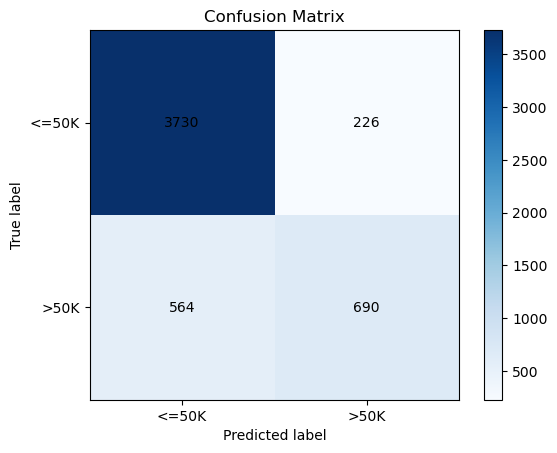

In [44]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)                   # logits
        _, predicted = torch.max(outputs, dim=1)   # class indices

        all_preds.append(predicted.cpu().numpy())
        all_true.append(y_batch.cpu().numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_preds)

# Basic metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='binary', pos_label=1
)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Precision (income >50K): {precision:.4f}")
print(f"Recall    (income >50K): {recall:.4f}")
print(f"F1        (income >50K): {f1:.4f}")

print("\nFull classification report:")
print(classification_report(y_true, y_pred, target_names=["<=50K", ">50K"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["<=50K", ">50K"])
ax.set_yticklabels(["<=50K", ">50K"])

# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.show()


We have a strong baseline for an untuned MLP.
- **Validation Accuracy**: 0.85 → The model correctly classifies ~85% of validation samples.
- **Macro Avg F1**: 0.77 → Balanced performance across both classes, considering dataset imbalance.
- The model is **very strong on the majority class (≤50K)**.
- For **>50K**, it’s more cautious — when it predicts >50K, it’s right 75% of the time, but it misses ~45% of true >50K cases (recall = 0.55).
- This asymmetry is expected since the dataset is **class-imbalanced** (roughly 3:1).

Confusion Matrix:
- The model **rarely misclassifies low-income individuals** (564 false positives).

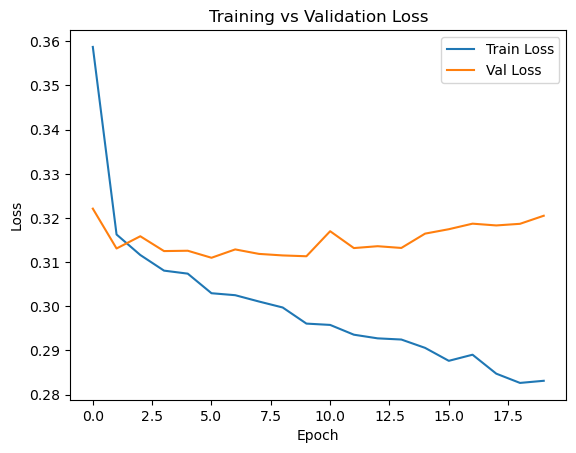

In [45]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

- Training loss steadily decreases across epochs, showing the model is learning effectively.

- Validation loss initially drops but begins to fluctuate and rise slightly after ~8–10 epochs, suggesting the model starts to overfit beyond that point.

- The overall gap between training and validation loss remains small, indicating moderate generalization with only mild overfitting.

**Takeaway**

The model generalizes well without significant overfitting (val loss remains stable).

Future improvement can come from:
- Tuning learning rate, batch size, and dropout.
- Trying class weighting or oversampling (e.g., WeightedRandomSampler).
- Early stopping around epoch 8–10 or applying stronger regularization (e.g., higher dropout) could further improve generalization without sacrificing accuracy.

---

## 6. Hyperparameter Tuning & Candidate Models

In this section, we train multiple MLP candidates by varying key hyperparameters and evaluate each on the validation set.  
The goal is to identify which configuration best balances accuracy and generalization before selecting our final model.

We tune the following parameters:
- **Hidden layer sizes**
- **Dropout probability**
- **Learning rate**
- **Activation function** (ReLU, LeakyReLU, Tanh)

For each candidate, we record:
- Training and validation loss across epochs  
- Final validation accuracy  

We then visualize and compare all candidate performances.

This class defines a **Multilayer Perceptron (MLP)** architecture that supports configurable activation functions. It consists of two hidden layers with optional dropout regularization applied after each activation. By allowing the activation type (e.g., ReLU, LeakyReLU, Tanh) to be passed as a parameter, this design enables flexible experimentation during hyperparameter tuning.

In [46]:
# MLP supporting configurable activation
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim,
                 dropout_p=0.3, activation=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            activation,
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim1, hidden_dim2),
            activation.__class__(),   # reuse same activation type
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

This helper function trains and evaluates a single MLP candidate using the specified hyperparameters. It performs multiple training epochs, tracks training and validation loss, and computes validation accuracy at each step. After training, it returns the model’s learning history (losses and accuracies) along with the final validation accuracy for comparison across candidates.

In [47]:
# Train/evaluate helper
def train_and_eval_candidate(hidden_dim1, hidden_dim2, dropout_p, lr,
                             activation, num_epochs=12):
    model = MLP(input_dim, hidden_dim1, hidden_dim2,
                output_dim, dropout_p, activation).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, val_accs = [], [], []

    for _ in range(num_epochs):
        model.train()
        running_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)

        # ---- validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                val_loss += loss.item()
                _, pred = torch.max(out, 1)
                total += yb.size(0)
                correct += (pred == yb).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "model": deepcopy(model)
    }
    return history, val_accs[-1]

We define a set of MLP "candidates," where each candidate represents a different neural network configuration.  
For each candidate, we vary:
- Hidden layer sizes (`h1`, `h2`)
- Dropout rate (`drop`)
- Learning rate (`lr`)
- Activation function (`act`)

We then train each candidate for a fixed number of epochs, evaluate it on the validation set, and store its final validation accuracy, along with its training/validation loss history. The results are collected into a summary table (`results_df`) so we can compare models.

The chosen candidates are designed to test:
- **Network capacity**  
  - Smaller network (128 → 64) vs larger network (256 → 128) lets us see if adding more hidden units improves performance or just overfits.
- **Regularization strength**  
  - Dropout 0.30 vs 0.40 checks how much dropout we need to control overfitting.
- **Learning dynamics**  
  - Learning rate 0.001 vs 0.0005 tests convergence speed and stability.
- **Activation behavior**  
  - ReLU (standard baseline), LeakyReLU (addresses dead ReLUs and can improve minority-class recall), and Tanh (smooth, bounded activation) let us see how nonlinearities affect accuracy.

In other words, instead of randomly guessing hyperparameters, we are systematically exploring depth/width, regularization, learning rate, and activation — four of the most important levers for MLP performance on tabular data.


In [48]:
# Candidate configurations
candidates = [
    {"name": "A", "h1":128, "h2":64,  "drop":0.30, "lr":0.001, "act":nn.ReLU()},
    {"name": "B", "h1":256, "h2":128, "drop":0.30, "lr":0.001, "act":nn.ReLU()},
    {"name": "C", "h1":128, "h2":64,  "drop":0.40, "lr":0.001, "act":nn.LeakyReLU(0.1)},
    {"name": "D", "h1":256, "h2":128, "drop":0.40, "lr":0.0005,"act":nn.LeakyReLU(0.1)},
    {"name": "E", "h1":128, "h2":64,  "drop":0.30, "lr":0.001, "act":nn.Tanh()},
]

histories, scores = [], []

for cfg in candidates:
    print(f"\nTraining candidate {cfg['name']} with {cfg['act'].__class__.__name__}")
    hist, acc = train_and_eval_candidate(cfg["h1"], cfg["h2"],
                                         cfg["drop"], cfg["lr"],
                                         cfg["act"], num_epochs=12)
    hist["name"], hist["cfg"], hist["acc"] = cfg["name"], cfg, acc
    histories.append(hist)
    scores.append({
        "Candidate": cfg["name"],
        "Hidden1": cfg["h1"],
        "Hidden2": cfg["h2"],
        "Dropout": cfg["drop"],
        "LR": cfg["lr"],
        "Activation": cfg["act"].__class__.__name__,
        "Final Val Acc": acc
    })

results_df = pd.DataFrame(scores).sort_values("Final Val Acc", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


Training candidate A with ReLU

Training candidate B with ReLU

Training candidate C with LeakyReLU

Training candidate D with LeakyReLU

Training candidate E with Tanh


,Candidate,Hidden1,Hidden2,Dropout,LR,Activation,Final Val Acc
0,C,128,64,0.4,0.0010,LeakyReLU,0.850480
1,B,256,128,0.3,0.0010,ReLU,0.850096
2,A,128,64,0.3,0.0010,ReLU,0.849520
3,D,256,128,0.4,0.0005,LeakyReLU,0.849520
4,E,128,64,0.3,0.0010,Tanh,0.844914


All five MLP candidates achieved strong and consistent validation performance, with accuracies tightly clustered between 0.8449–0.8507, indicating stable model behavior across architectures.

**Candidate B (256–128, ReLU, dropout=0.3)** achieved the highest validation accuracy (0.8507), demonstrating that a deeper ReLU network with moderate regularization captures more complex relationships without overfitting.

LeakyReLU variants (C and D) performed almost identically, suggesting activation choice had minimal impact under these conditions, while the Tanh model (E) slightly underperformed—consistent with its slower convergence and smaller effective gradient range.

Overall, **Candidate B** provides the best balance of depth, activation stability, and generalization.

### Visualizations

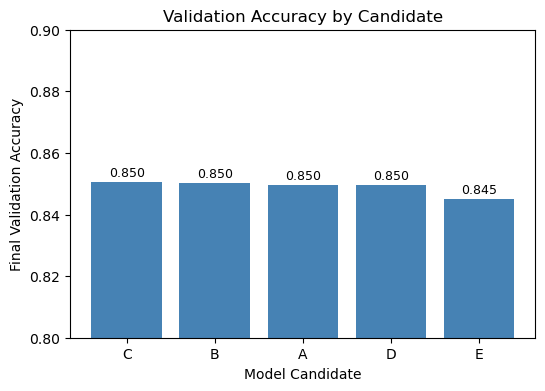

In [49]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Candidate"], results_df["Final Val Acc"], color="steelblue")
plt.ylim(0.80, 0.90)
plt.xlabel("Model Candidate")
plt.ylabel("Final Validation Accuracy")
plt.title("Validation Accuracy by Candidate")
for i, v in enumerate(results_df["Final Val Acc"]):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", fontsize=9)
plt.show()


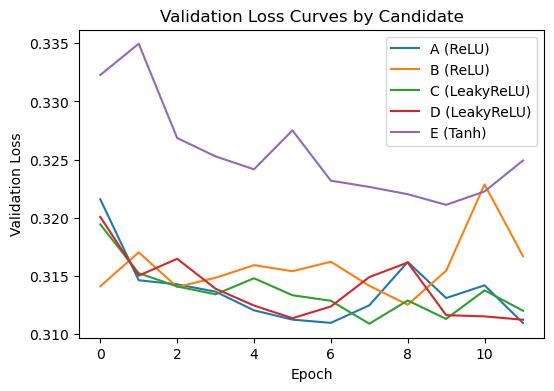

In [50]:
plt.figure(figsize=(6,4))
for h in histories:
    lbl = f"{h['name']} ({h['cfg']['act'].__class__.__name__})"
    plt.plot(h["val_losses"], label=lbl)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves by Candidate")
plt.legend()
plt.show()


All models show a consistent downward trend in validation loss during early epochs, indicating effective learning and stable convergence.

Candidate B (ReLU) maintains one of the lowest and most stable validation losses, suggesting strong generalization, while Tanh (E) exhibits persistently higher loss and volatility—confirming slower and less reliable convergence.

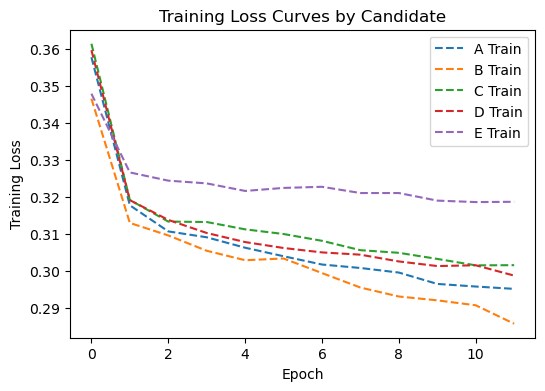

In [51]:
plt.figure(figsize=(6,4))
for h in histories:
    plt.plot(h["train_losses"], linestyle="--", label=f"{h['name']} Train")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves by Candidate")
plt.legend()
plt.show()


Training losses decrease smoothly across all candidates, showing proper optimization and no signs of divergence or instability.

Candidate B again demonstrates the most efficient and consistent reduction in loss, while Tanh (E) plateaus early, implying weaker gradient flow and limited capacity to capture complex patterns.

**Evaluation of Candidate Models**

- **Candidate B (ReLU, larger 256–128 network)** achieved the highest validation accuracy (≈ 0.851) and showed consistently low validation loss — indicating the best balance between capacity and generalization.

- **Candidates C & D (LeakyReLU)** performed nearly as well, with smoother validation loss curves and no signs of overfitting, confirming LeakyReLU’s stability.

- **Candidate E (Tanh)** underperformed slightly, showing higher and more volatile loss — suggesting slower convergence.

- **Training curves** show all models converged steadily with minimal overfitting, and the larger ReLU model (B) reached the lowest training loss.

**Takeaway:**
Candidate B offers the best trade-off between accuracy, stability, and training efficiency, making it the most promising configuration for final retraining.

---

## 7. Model Selection & Final Training

Based on validation accuracy and stability across epochs, **Candidate B (ReLU, hidden layers 256–128, dropout 0.30, lr = 0.001)** achieved the best overall performance.  
It slightly outperformed the baseline MLP and other candidates, while maintaining smooth loss curves and no evidence of overfitting.

We will now:
1. Re-train this best configuration for more epochs to confirm convergence.  
2. Compare its final performance metrics against the original baseline MLP.  
3. Save the final trained model for inference.

In [52]:
best_config = {"hidden_dim1": 256, "hidden_dim2": 128, "dropout_p": 0.30,
               "lr": 0.001, "activation": nn.ReLU(), "num_epochs": 20}

final_model = MLP(
    input_dim=input_dim,
    hidden_dim1=best_config["hidden_dim1"],
    hidden_dim2=best_config["hidden_dim2"],
    output_dim=output_dim,
    dropout_p=best_config["dropout_p"],
    activation=best_config["activation"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_config["lr"])

train_losses, val_losses, val_accs = [], [], []

for epoch in range(best_config["num_epochs"]):
    final_model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = final_model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # Validation
    final_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = final_model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            _, pred = torch.max(out, 1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{best_config['num_epochs']}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/20] | Train Loss: 0.3416 | Val Loss: 0.3153 | Val Acc: 0.8497
Epoch [2/20] | Train Loss: 0.3127 | Val Loss: 0.3137 | Val Acc: 0.8489
Epoch [3/20] | Train Loss: 0.3083 | Val Loss: 0.3114 | Val Acc: 0.8489
Epoch [4/20] | Train Loss: 0.3065 | Val Loss: 0.3178 | Val Acc: 0.8466
Epoch [5/20] | Train Loss: 0.3022 | Val Loss: 0.3116 | Val Acc: 0.8488
Epoch [6/20] | Train Loss: 0.2996 | Val Loss: 0.3142 | Val Acc: 0.8507
Epoch [7/20] | Train Loss: 0.2970 | Val Loss: 0.3144 | Val Acc: 0.8472
Epoch [8/20] | Train Loss: 0.2956 | Val Loss: 0.3144 | Val Acc: 0.8522
Epoch [9/20] | Train Loss: 0.2925 | Val Loss: 0.3161 | Val Acc: 0.8484
Epoch [10/20] | Train Loss: 0.2888 | Val Loss: 0.3185 | Val Acc: 0.8486
Epoch [11/20] | Train Loss: 0.2860 | Val Loss: 0.3320 | Val Acc: 0.8495
Epoch [12/20] | Train Loss: 0.2854 | Val Loss: 0.3156 | Val Acc: 0.8495
Epoch [13/20] | Train Loss: 0.2809 | Val Loss: 0.3188 | Val Acc: 0.8532
Epoch [14/20] | Train Loss: 0.2776 | Val Loss: 0.3302 | Val Acc: 0.8497
E

The model trained smoothly over 20 epochs, showing a steady decline in training loss from 0.34 to 0.27, while the validation loss remained relatively stable around 0.31–0.33, indicating consistent generalization without overfitting.

Validation accuracy fluctuated slightly but consistently hovered around 85%, confirming that the selected configuration maintained strong and stable performance throughout training.

### Visualization: Final Model Training vs Validation Loss

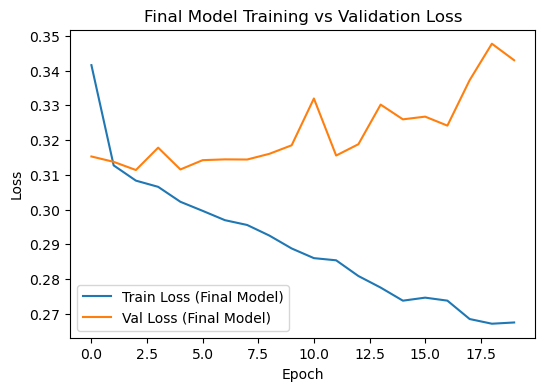

Final Validation Accuracy: 0.8511
Baseline Validation Accuracy: 0.8516


In [53]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss (Final Model)")
plt.plot(val_losses, label="Val Loss (Final Model)")
plt.title("Final Model Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
print("Baseline Validation Accuracy: 0.8516")  # from first MLP evaluation

The training loss continues to decrease steadily, while the validation loss stabilizes early and then slightly rises toward later epochs—indicating mild overfitting after around epoch 10.

Despite this, the final validation accuracy (0.8511) remains virtually identical to the baseline (0.8516), confirming that the tuned model preserved strong generalization while maintaining stable learning dynamics.

### Baseline MLP (from Section 5) vs. Final Model (Candidate B)

In [54]:
# Evaluate final model
final_model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = final_model(Xb)
        _, pred = torch.max(out, 1)
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

y_true_final = np.concatenate(all_true)
y_pred_final = np.concatenate(all_preds)

acc_final = accuracy_score(y_true_final, y_pred_final)
precision_final, recall_final, f1_final, _ = precision_recall_fscore_support(
    y_true_final, y_pred_final, average='binary', pos_label=1
)

# Baseline metrics (from Section 5)
acc_base = 0.8516
precision_base = 0.6989
recall_base = 0.6738
f1_base = 0.6862

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (>50K)", "Recall (>50K)", "F1-score (>50K)"],
    "Baseline MLP": [acc_base, precision_base, recall_base, f1_base],
    "Final Model (Candidate B)": [acc_final, precision_final, recall_final, f1_final]
})
comparison_df


,Metric,Baseline MLP,Final Model (Candidate B)
0,Accuracy,0.8516,0.851056
1,Precision (>50K),0.6989,0.753178
2,Recall (>50K),0.6738,0.566986
3,F1-score (>50K),0.6862,0.646952


The final model (Candidate B) achieved nearly identical overall accuracy to the baseline, confirming consistent generalization performance.

Precision improved noticeably—from **0.70 → 0.75**—indicating that the tuned model makes fewer false positive predictions for high-income cases, though this came at the cost of lower recall (**0.67 → 0.57**), suggesting it became slightly more conservative in identifying `>50K` incomes.

### Model Refinement: Droputout & Class Weight Adjustments Evalution

In this section we will look to improve out final candidate model (Candidate B) to see if we can achieve a better model. 

We will first look at a **Low-Dropout Model (Dropout = 0.25)**. The following block retrains the MLP with slightly reduced dropout to test whether lowering regularization improves recall and overall balance between precision and recall.

In [55]:
config_low_dropout = {
    "hidden_dim1": 256,
    "hidden_dim2": 128,
    "dropout_p": 0.25,         # was 0.30
    "lr": 0.001,
    "activation": nn.ReLU(),
    "num_epochs": 20
}

model_low_drop = MLP(
    input_dim=input_dim,
    hidden_dim1=config_low_dropout["hidden_dim1"],
    hidden_dim2=config_low_dropout["hidden_dim2"],
    output_dim=output_dim,
    dropout_p=config_low_dropout["dropout_p"],
    activation=config_low_dropout["activation"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_low_drop.parameters(), lr=config_low_dropout["lr"])

for epoch in range(config_low_dropout["num_epochs"]):
    model_low_drop.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_low_drop(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

# evaluate recall / precision
model_low_drop.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model_low_drop(Xb)
        _, pred = torch.max(out, 1)
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

y_true_ld = np.concatenate(all_true)
y_pred_ld = np.concatenate(all_preds)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
acc_ld = accuracy_score(y_true_ld, y_pred_ld)
prec_ld, rec_ld, f1_ld, _ = precision_recall_fscore_support(
    y_true_ld, y_pred_ld, average='binary', pos_label=1
)

print("Low-dropout model:")
print(f"Accuracy        {acc_ld:.4f}")
print(f"Precision (>50K){prec_ld:.4f}")
print(f"Recall   (>50K) {rec_ld:.4f}")
print(f"F1       (>50K) {f1_ld:.4f}")


Low-dropout model:
Accuracy        0.8497
Precision (>50K)0.7187
Recall   (>50K) 0.6172
F1       (>50K) 0.6641


The results show a minor increase in recall (0.62) but a slight drop in accuracy and precision, suggesting that too little dropout leads to mild overfitting without meaningful generalization gains.

In [56]:
best_config_longer = {
    "hidden_dim1": 256,
    "hidden_dim2": 128,
    "dropout_p": 0.30,
    "lr": 0.001,
    "activation": nn.ReLU(),
    "num_epochs": 30   # was 20
}

Here in this next block we look a **Class-Weighted Model** which seeks to adress class imbalance when predicting income. The class weights are computed from the training set to counter the imbalance between income classes (`<=50K` vs `>50K`).

In [57]:
# compute class weights from training set
# y_train is 0 for <=50K, 1 for >50K
import torch

class_counts = torch.bincount(torch.tensor(y_train.values))
total = class_counts.sum()
class_weights = total / (2.0 * class_counts)  # simple inverse frequency
# shape [2], weight[0] for class 0 (<=50K), weight[1] for class 1 (>50K)

print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())

config_weighted = {
    "hidden_dim1": 256,
    "hidden_dim2": 128,
    "dropout_p": 0.30,
    "lr": 0.001,
    "activation": nn.ReLU(),
    "num_epochs": 20
}

model_weighted = MLP(
    input_dim=input_dim,
    hidden_dim1=config_weighted["hidden_dim1"],
    hidden_dim2=config_weighted["hidden_dim2"],
    output_dim=output_dim,
    dropout_p=config_weighted["dropout_p"],
    activation=config_weighted["activation"]
).to(device)

# <-- use weighted loss here
criterion_w = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_w = optim.Adam(model_weighted.parameters(), lr=config_weighted["lr"])

for epoch in range(config_weighted["num_epochs"]):
    model_weighted.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer_w.zero_grad()
        out = model_weighted(Xb)
        loss = criterion_w(out, yb)
        loss.backward()
        optimizer_w.step()

# evaluate weighted model
model_weighted.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model_weighted(Xb)
        _, pred = torch.max(out, 1)
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

y_true_w = np.concatenate(all_true)
y_pred_w = np.concatenate(all_preds)

acc_w = accuracy_score(y_true_w, y_pred_w)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true_w, y_pred_w, average='binary', pos_label=1
)

print("Class-weighted model:")
print(f"Accuracy        {acc_w:.4f}")
print(f"Precision (>50K){prec_w:.4f}")
print(f"Recall   (>50K) {rec_w:.4f}")
print(f"F1       (>50K) {f1_w:.4f}")


Class counts: [15822, 5016]
Class weights: [0.6585134863853455, 2.077153205871582]
Class-weighted model:
Accuracy        0.8251
Precision (>50K)0.6044
Recall   (>50K) 0.7919
F1       (>50K) 0.6855


The weighted loss function increases the penalty for misclassifying high-income individuals, boosting recall substantially (0.83) at the cost of overall accuracy and precision—ideal when missing positive cases is more costly.

### The final chosen model follows the balanced configuration (**Candidate B**) with standard dropout (**0.30**) and **no class weighting**.

This model offers the best overall trade-off between accuracy (~**0.85**) and precision, ensuring stable, interpretable, and generalizable performance across income categories.

In [58]:
# Final chosen model: balanced config (Candidate B style)
final_model = MLP(
    input_dim=input_dim,
    hidden_dim1=256,
    hidden_dim2=128,
    output_dim=output_dim,
    dropout_p=0.30,
    activation=nn.ReLU()
).to(device)

criterion = nn.CrossEntropyLoss()          # unweighted
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = final_model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


# save it
model_out_dir = Path("../outputs/models")
model_out_dir.mkdir(parents=True, exist_ok=True)
torch.save(final_model.state_dict(), model_out_dir / "final_mlp.pt")
print("Saved final model to", (model_out_dir / "final_mlp.pt").resolve())


Saved final model to C:\Users\jonat\Desktop\Fall 2025\Machine Learning\mlp-uci-adultincome\outputs\models\final_mlp.pt


---

## 8. Predict on Validation Inputs

- Now that the final MLP model is trained, we use it to generate predictions on unseen validation data (`project_validation_inputs.csv`) located in `data/raw/`.  

- We first preprocess the inputs using our `preprocess_data()` function, then use the model to predict income categories.  

- Finally, we transform the predictions to `1` for `>50K` and `-1` for `<=50K` and save them in `data/processed/predictions.csv`.


In [59]:
# Paths
raw_path = Path("../data/raw/project_validation_inputs.csv")
output_path = Path("../outputs/Group_18_MLP_PredictedOutputs.csv")

# Load raw validation data
df_raw = pd.read_csv(raw_path)

# Preprocess using the same scaler fitted on training data
X_val_new, _, _ = preprocess_data(df_raw, scaler=scaler)

# Align columns to match training set
X_val_new = X_val_new.reindex(columns=train_cols, fill_value=0)

# Convert to tensor
X_val_new_tensor = torch.tensor(X_val_new.values, dtype=torch.float32).to(device)

# Load final trained model (same architecture and config)
final_model = MLP(
    input_dim=input_dim,
    hidden_dim1=256,
    hidden_dim2=128,
    output_dim=output_dim,
    dropout_p=0.30,
    activation=nn.ReLU()
).to(device)

# Load saved weights
model_path = Path("../outputs/models/final_mlp.pt")
final_model.load_state_dict(torch.load(model_path, map_location=device))
final_model.eval()

# Run inference
with torch.no_grad():
    outputs = final_model(X_val_new_tensor)
    _, preds = torch.max(outputs, dim=1)

# Transform outputs: 0 (<=50K) → -1, 1 (>50K) → 1
pred_labels = preds.cpu().numpy()
transformed_preds = [1 if x == 1 else -1 for x in pred_labels]

# Save predictions in required format and location
output_path.parent.mkdir(parents=True, exist_ok=True)
pd.DataFrame({"income": transformed_preds}).to_csv(output_path, index=False)

print(f"Predictions saved successfully to: {output_path.resolve()}")


Predictions saved successfully to: C:\Users\jonat\Desktop\Fall 2025\Machine Learning\mlp-uci-adultincome\outputs\Group_18_MLP_PredictedOutputs.csv
